In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from timm import create_model  # For ResNet50 and ViT models
from sklearn.metrics import classification_report, matthews_corrcoef

In [2]:
DATASET_PATH = "/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2" 
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data Augmentation and Preprocessing
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
# Load Dataset
dataset = ImageFolder(DATASET_PATH, transform=transform)
num_classes = len(dataset.classes)

In [5]:
# Split Dataset
indices = list(range(len(dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(test_idx, test_size=0.66, random_state=42)

In [6]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

In [7]:
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class HybridResNet50ViT(nn.Module):
    def __init__(self, num_classes):
        super(HybridResNet50ViT, self).__init__()
        # Pre-trained ResNet50
        self.resnet = create_model('resnet50', pretrained=True, num_classes=num_classes)
        # Pre-trained Vision Transformer
        self.vit = create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
        # Fully connected layers to combine features
        self.fc = nn.Sequential(
            nn.Linear(2 * num_classes, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        return self.fc(combined_features)

In [9]:
# Initialize the Model
model = HybridResNet50ViT(num_classes)
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

HybridResNet50ViT(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e

In [10]:
# Loss Function: Cross-Entropy Loss
criterion = nn.CrossEntropyLoss()

In [11]:
# Optimizer: AdamW
optimizer = optim.AdamW(model.parameters(), lr=LR)

In [12]:
# Training Function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / len(loader), 100.0 * correct / total

In [13]:
# Validation Function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    preds_list, labels_list = [], []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    mcc = matthews_corrcoef(labels_list, preds_list)
    return total_loss / len(loader), 100.0 * correct / total, mcc

In [14]:
# Training Loop
best_mcc = 0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc, val_mcc = validate_epoch(model, val_loader, criterion, DEVICE)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val MCC: {val_mcc:.4f}")

    # Save the best model
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    if val_mcc > best_mcc:
        best_mcc = val_mcc
        torch.save(model.state_dict(), "best_resnet50_vit_model.pth")
        print(f"Best model saved with MCC: {val_mcc:.4f}")

Epoch 1/10


Validation: 100%|██████████| 51/51 [00:30<00:00,  1.68it/s]


Train Loss: 1.0187, Train Acc: 56.18%
Val Loss: 0.5114, Val Acc: 74.39%, Val MCC: 0.7242
Best model saved with MCC: 0.7242
Epoch 2/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


Train Loss: 0.5313, Train Acc: 78.36%
Val Loss: 0.4058, Val Acc: 81.37%, Val MCC: 0.7963
Best model saved with MCC: 0.7963
Epoch 3/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  2.00it/s]


Train Loss: 0.3682, Train Acc: 85.46%
Val Loss: 0.3143, Val Acc: 87.13%, Val MCC: 0.8554
Best model saved with MCC: 0.8554
Epoch 4/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  1.99it/s]


Train Loss: 0.3113, Train Acc: 88.12%
Val Loss: 0.2459, Val Acc: 90.56%, Val MCC: 0.8930
Best model saved with MCC: 0.8930
Epoch 5/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  1.97it/s]


Train Loss: 0.2497, Train Acc: 90.20%
Val Loss: 0.3748, Val Acc: 86.52%, Val MCC: 0.8512
Epoch 6/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


Train Loss: 0.2251, Train Acc: 91.75%
Val Loss: 0.2990, Val Acc: 89.71%, Val MCC: 0.8846
Epoch 7/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  1.97it/s]


Train Loss: 0.2163, Train Acc: 91.71%
Val Loss: 0.2573, Val Acc: 90.07%, Val MCC: 0.8873
Epoch 8/10


Validation: 100%|██████████| 51/51 [00:26<00:00,  1.95it/s]


Train Loss: 0.2117, Train Acc: 92.27%
Val Loss: 0.3511, Val Acc: 88.24%, Val MCC: 0.8675
Epoch 9/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  1.98it/s]


Train Loss: 0.1853, Train Acc: 93.43%
Val Loss: 0.3039, Val Acc: 90.07%, Val MCC: 0.8886
Epoch 10/10


Validation: 100%|██████████| 51/51 [00:25<00:00,  2.00it/s]

Train Loss: 0.1660, Train Acc: 94.05%
Val Loss: 0.2663, Val Acc: 89.46%, Val MCC: 0.8797


In [15]:
# Evaluate on Test Data
model.load_state_dict(torch.load("best_resnet50_vit_model.pth"))
model.eval()
test_loss, test_acc, test_mcc = validate_epoch(model, test_loader, criterion, DEVICE)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%, Test MCC: {test_mcc:.4f}")

<ipython-input-15-f971c8a785fe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_resnet50_vit_model.pth"))
Validation: 100%|██████████

Test Loss: 0.2492, Test Accuracy: 90.47%, Test MCC: 0.8918


In [16]:
# Classification Report
y_true = []
y_pred = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))


Classification Report:
                        precision    recall  f1-score   support

    dyed-lifted-polyps       0.85      0.98      0.91       202
dyed-resection-margins       0.98      0.83      0.90       216
           esophagitis       0.85      0.72      0.78       195
          normal-cecum       0.94      0.96      0.95       176
        normal-pylorus       0.97      1.00      0.98       202
         normal-z-line       0.77      0.87      0.82       206
                polyps       0.90      0.96      0.93       195
    ulcerative-colitis       0.98      0.88      0.93       192

              accuracy                           0.90      1584
             macro avg       0.90      0.90      0.90      1584
          weighted avg       0.90      0.90      0.90      1584



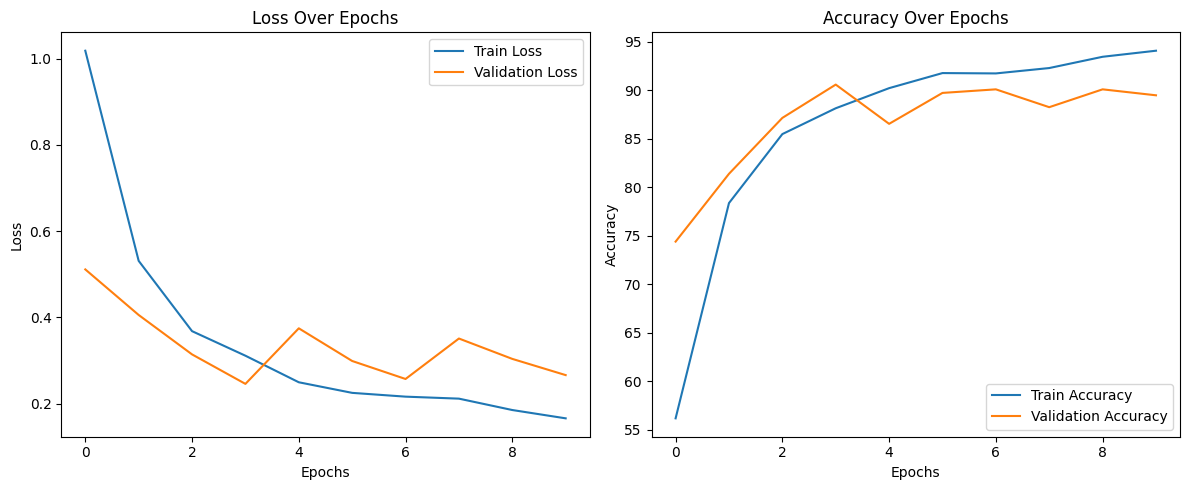

In [17]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
from PIL import Image
import torch
from torchvision import transforms

# Path to the saved model
MODEL_PATH = "best_resnet50_vit_model.pth"

# Load the trained model
model = HybridResNet50ViT(num_classes)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

<ipython-input-18-2aaac7ae3d56>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))


HybridResNet50ViT(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e

In [19]:
# Define the transformation (same as training)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [20]:
# Load and preprocess the test image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image and ensure it's in RGB
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension
    return image

In [21]:
# Predict function
def predict(image_path):
    image = preprocess_image(image_path).to(DEVICE)  # Preprocess and move to DEVICE
    with torch.no_grad():
        output = model(image)  # Forward pass
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Convert logits to probabilities
        predicted_class = torch.argmax(probabilities, dim=1).item()  # Get the class with the highest probability
    return predicted_class, probabilities[0]

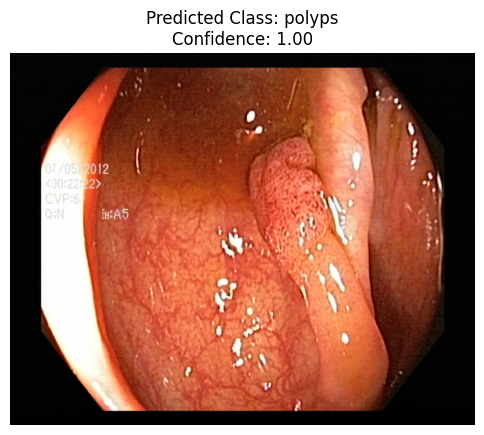

Class Probabilities:
  dyed-lifted-polyps: 0.0001
  dyed-resection-margins: 0.0000
  esophagitis: 0.0000
  normal-cecum: 0.0000
  normal-pylorus: 0.0000
  normal-z-line: 0.0000
  polyps: 0.9998
  ulcerative-colitis: 0.0001


In [22]:
# Display the image with predictions
def display_image_with_prediction(image_path):
    image = Image.open(image_path).convert("RGB")  # Open the image
    predicted_class, probabilities = predict(image_path)  # Get prediction

    # Get class names from the dataset
    class_names = dataset.classes

    # Display the image with prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted Class: {class_names[predicted_class]}\n"
              f"Confidence: {probabilities[predicted_class]:.2f}")
    plt.show()

    # Print all class probabilities
    print("Class Probabilities:")
    for idx, prob in enumerate(probabilities):
        print(f"  {class_names[idx]}: {prob:.4f}")

# Example Usage
test_image_path = "/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2/polyps/006338df-e61e-4725-bb6c-dd0620f11cdc.jpg" 
display_image_with_prediction(test_image_path)

#  Explainable AI 

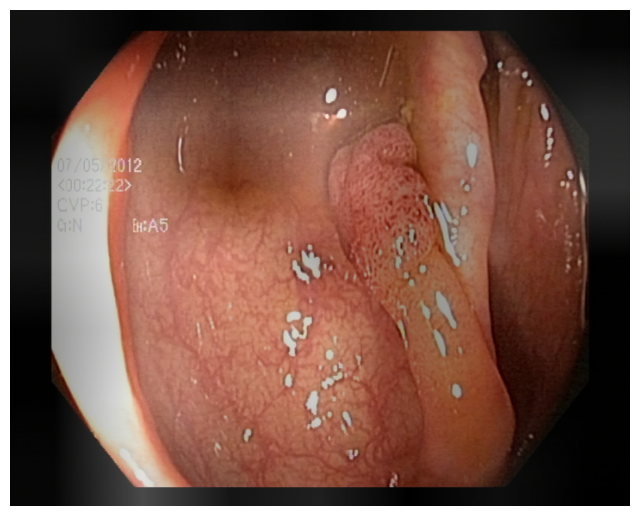

In [27]:
# Example usage
# Provide a test image path and class index
test_image_path = "/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2/polyps/006338df-e61e-4725-bb6c-dd0620f11cdc.jpg"
predicted_class = 6  # Replace with the predicted class index
explain_prediction(model, test_image_path, predicted_class)

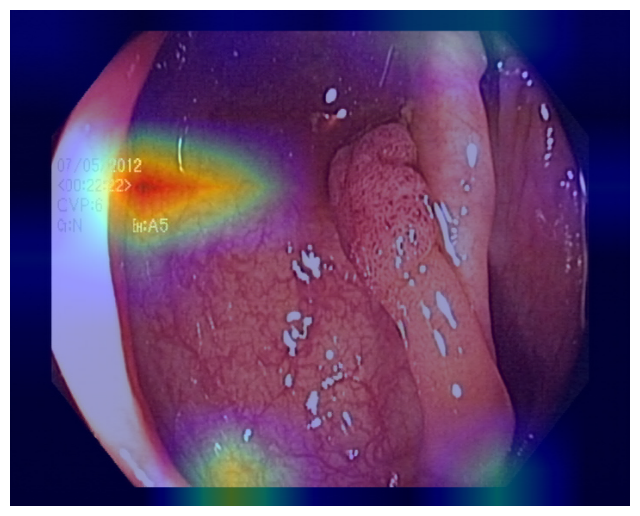

In [28]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from timm import create_model

# Constants
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

# Grad-CAM implementation
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def save_activations(self, module, input, output):
        self.activations = output

    def generate_heatmap(self, class_idx):
        if self.gradients is None or self.activations is None:
            raise ValueError("Gradients or activations were not captured properly.")

        gradients = self.gradients.cpu().data.numpy()[0]  # [channels, height, width]
        activations = self.activations.cpu().data.numpy()[0]  # [channels, height, width]

        # Compute the weights
        weights = np.mean(gradients, axis=(1, 2))  # Global average pooling

        # Compute the weighted sum of the feature maps
        heatmap = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            heatmap += w * activations[i]

        # Normalize heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max() + 1e-8
        return heatmap

# Function to overlay heatmap on the image
def overlay_heatmap(image_path, heatmap, alpha=0.4):
    original_image = Image.open(image_path).convert("RGB")
    heatmap = np.uint8(255 * heatmap)
    heatmap = Image.fromarray(heatmap).resize(original_image.size, resample=Image.BILINEAR)
    heatmap = np.array(heatmap)

    # Apply colormap
    colormap = plt.cm.jet(heatmap / 255.0)[:, :, :3]  # RGB values only
    colormap = np.uint8(colormap * 255)

    # Overlay heatmap
    overlay = np.array(original_image) * (1 - alpha) + colormap * alpha
    overlay = np.uint8(overlay)

    # Display
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

# Hybrid model class
class HybridResNetViT(nn.Module):
    def __init__(self, num_classes):
        super(HybridResNetViT, self).__init__()
        self.resnet = create_model("resnet50", pretrained=True, num_classes=num_classes)
        self.vit = create_model("vit_base_patch16_224", pretrained=True, num_classes=num_classes)
        self.fc = nn.Sequential(
            nn.Linear(2 * num_classes, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        resnet_features = self.resnet(x)
        vit_features = self.vit(x)
        combined_features = torch.cat((resnet_features, vit_features), dim=1)
        return self.fc(combined_features)

# Initialize model
num_classes = 8  # Example class count, adjust as needed
model = HybridResNetViT(num_classes)
model.to(DEVICE)
model.eval()

# Explain prediction
def explain_prediction(model, image_path, class_idx):
    gradcam = GradCAM(model, model.resnet.layer4)  # Specify ResNet target layer

    # Preprocess image
    image = preprocess_image(image_path).to(DEVICE)

    # Forward pass
    output = model(image)

    # Backward pass for the target class
    model.zero_grad()
    target_class_score = output[:, class_idx]
    target_class_score.backward()

    # Generate Grad-CAM heatmap
    heatmap = gradcam.generate_heatmap(class_idx)

    # Overlay heatmap
    overlay_heatmap(image_path, heatmap)

# Example usage
# Provide a test image path and class index
test_image_path = "/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2/polyps/006338df-e61e-4725-bb6c-dd0620f11cdc.jpg"  # Replace with your test image path
predicted_class = 6  # Replace with the predicted class index
explain_prediction(model, test_image_path, predicted_class)


In [29]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install torch torchvision timm shap matplotlib pillow

Note: you may need to restart the kernel to use updated packages.


In [34]:
import shap
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Constants
IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Preprocessing function for the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization for pretrained models
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Load a pretrained model
from timm import create_model

model = create_model('resnet50', pretrained=True, num_classes=8)  # Replace with your dataset's num_classes
model.eval().to(DEVICE)

# SHAP Explanation Function
def explain_with_shap(model, image_path):
    # Load and preprocess the image
    image = preprocess_image(image_path).to(DEVICE)

    # Define a prediction function for SHAP
    def predict(images):
        images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2).to(DEVICE)  # NHWC -> NCHW
        images = (images - torch.tensor([0.485, 0.456, 0.406], device=DEVICE)) / torch.tensor([0.229, 0.224, 0.225], device=DEVICE)  # Normalize
        with torch.no_grad():
            outputs = model(images)
        return torch.softmax(outputs, dim=1).cpu().numpy()

    # Convert image back to NumPy array (for SHAP compatibility)
    image_np = image.squeeze().cpu().permute(1, 2, 0).numpy()
    image_np = (image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # De-normalize
    image_np = np.clip(image_np, 0, 1)

    # Initialize SHAP explainer
    background = np.random.randn(10, IMG_SIZE, IMG_SIZE, 3)  # Random background for SHAP
    explainer = shap.Explainer(predict, background)

    # Get SHAP values for the image
    shap_values = explainer([image_np])  # Wrap in a list for batch processing

    # Plot SHAP explanations
    shap.image_plot(shap_values, [image_np])

# Example usage
test_image_path = "/kaggle/input/the-kvasir-dataset/kvasir-dataset-v2/polyps/006338df-e61e-4725-bb6c-dd0620f11cdc.jpg"  # Replace with your image path
explain_with_shap(model, test_image_path)

TypeError: 'numpy.ndarray' object is not callable